<h1><center><b>SharpyAI</b></center></h1>

# **Context**

**"Are we alone in the universe?"**

It is one of the deepest human questions. As technology improves, we find new and more powerful ways to search for answers.
The Listen team is part of the Search for Extraterrestrial Intelligence (SETI) and uses the largest steerable dish on the planet, the 100 meter diameter Green Bank Telescope. Like any SETI search, the motivation to communicate is also the biggest challenge. Human beings have built an enormous number of radio devices. It's hard to look for a faint alien transmission needle in the huge haystack of modern technology detections.

Current methods use two filters to search the haystack. First, Listen's team intersperses scans of the target stars with scans of other regions of the sky. Any signal that appears in both sets of scans is probably not coming from the direction of the target star. Second, the pipeline discards signals that don't change their frequency, because this means they are probably close to the telescope. A moving source should have a signal suggesting movement, similar to the change in pitch of a passing fire truck's siren. These two filters are quite effective, but we know that they can be improved. Undoubtedly, channeling misses interesting signals, particularly those with a complex time or frequency structure, and those in regions of the spectrum with a lot of interference.

This project aims to help identify anomalous signals in Breakthrough Listen target scans

In [ ]:
import math
import os
import random
import warnings
from typing import *

import albumentations
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sn
import seaborn as sns
import timm
import gc
import torch
import torch.nn.functional as F
import torchvision
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensorV2
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      ReduceLROnPlateau, _LRScheduler)
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from tqdm import tqdm
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
clear_output()

# **Signal analysis**

In [ ]:
df_train = pd.read_csv("wowdao-autonomous-industry-dataset/train_labels.csv")
df_test  = pd.read_csv("wowdao-autonomous-industry-dataset/testing.csv")

In [ ]:
dist = df_train.target.map({0:'haystack', 1:'needle'})
dist = dist.value_counts()
fig = px.pie(dist,
             values='target',
             names=dist.index,
             hole=.4,title="Target Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

In [ ]:
px.histogram(df_train, y="target", color="target", title='Target Distribution')

Targets:

* 54000 Positive
* 6000 Negatives

In [ ]:
map_semantic = {}
map_semantic[0] = "needle"
map_semantic[1] = "haystack"

In [ ]:
def get_train_filename_by_id(image_id: str) -> str:
    """This function takes in an filename id and returns the path of this file.

    Args:
        image_id (str): [description]

    Returns:
        str: [description]
    """
    return f"wowdao-autonomous-industry-dataset/train/{image_id[0]}/{image_id}.npy"


def get_test_filename_by_id(image_id: str) -> str:
    """This function takes in an filename id and returns the path of this file.

    Args:
        image_id (str): An example of an image_id is cc9526e839463b1.
                        Note that image_id[0] = c gives you the subfolder containing images that starts with c.
                        You can see the usage in the return statement.

    Returns:
        str: [description]
    """
    return f"wowdao-autonomous-industry-dataset/test/{image_id[0]}/{image_id}.npy"

In [ ]:
# Seems need to find easy/hard images as the data refreshes

easy_image_1 = get_train_filename_by_id(image_id = 'cd73ff1954feeb9')
easy_image_2 = get_train_filename_by_id(image_id = '0e55f80554f8d36')
medium_image_1 = get_train_filename_by_id(image_id = '886f7aa765d6282')
medium_image_2 = get_train_filename_by_id(image_id = '56fe32cddc6d17e')
# This hard_image_1 is difficult because all channels seem to have signal but they are not.
hard_image_1 = get_train_filename_by_id(image_id = 'cc9526e839463b1')
hard_image_2 = get_train_filename_by_id(image_id = 'a5abd8d2eafd618')
test_image = get_test_filename_by_id(image_id = '10013eb3e11e199')

image_list : List[str] = [easy_image_1, easy_image_2,medium_image_1, medium_image_2,hard_image_1, hard_image_2]

In [ ]:
def show_cadence(filename: str, label: int) -> None:
    plt.figure(figsize=(16, 10))
    arr = np.load(filename)
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            plt.title(f"Id: {os.path.basename(filename)} Category: {map_semantic[label]}", fontsize=18)
        plt.imshow(arr[i].astype(float), interpolation='nearest', aspect='auto')
        plt.text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
        plt.xticks([])
    plt.show()

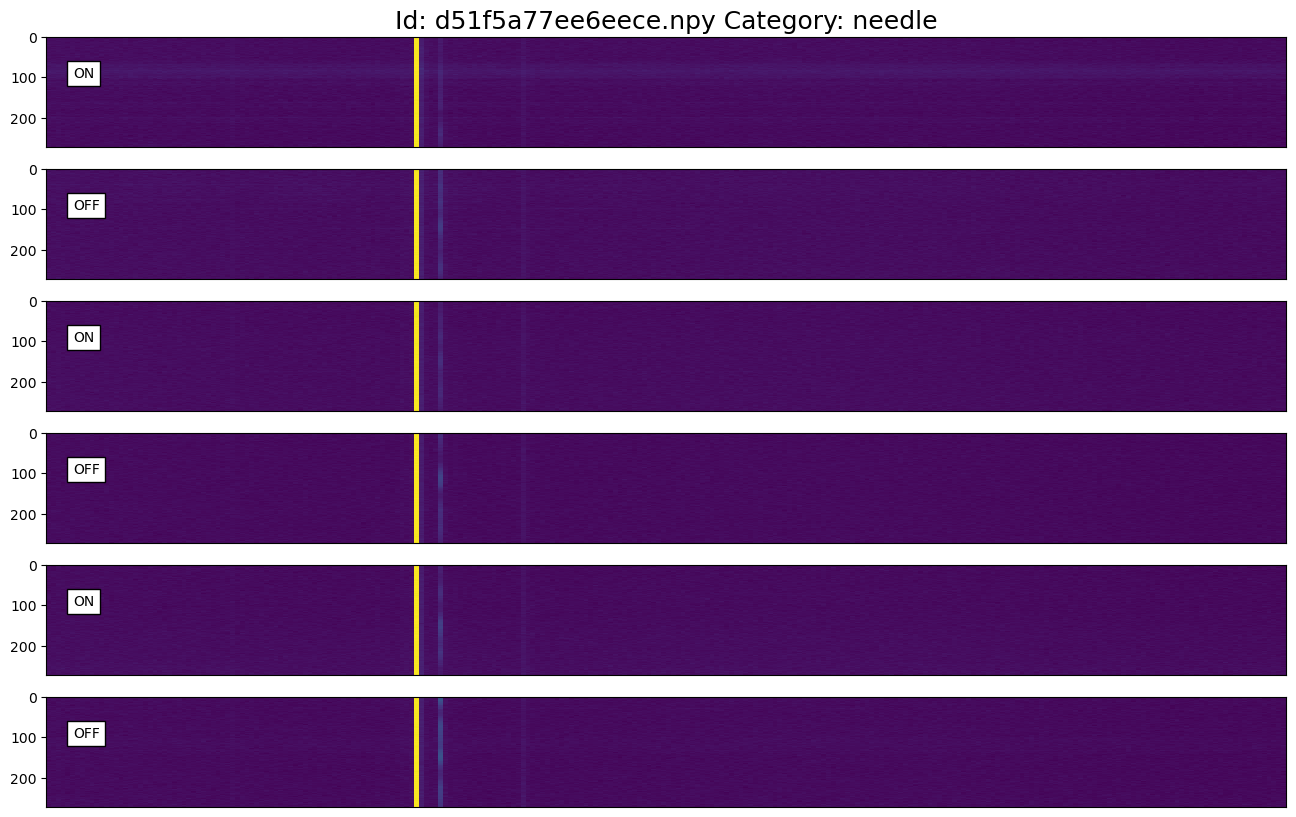

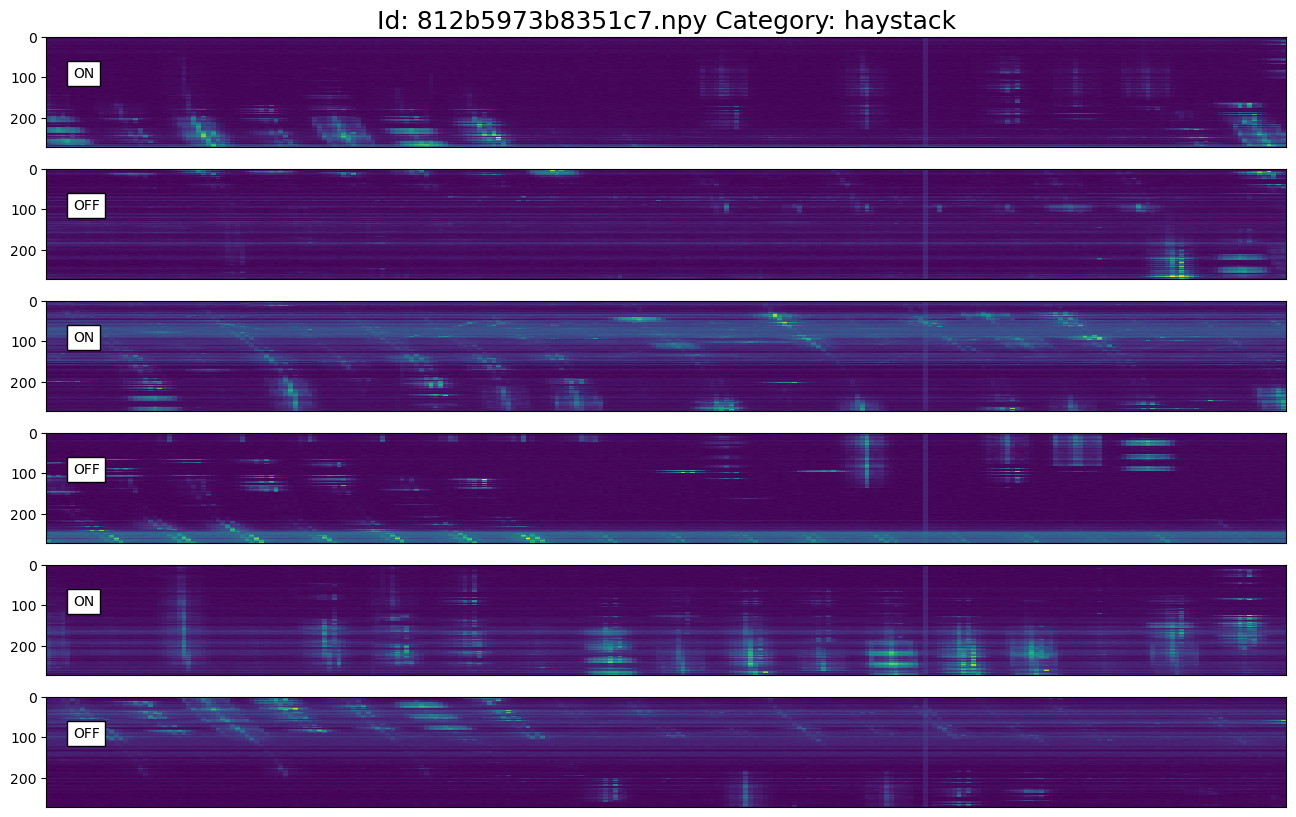

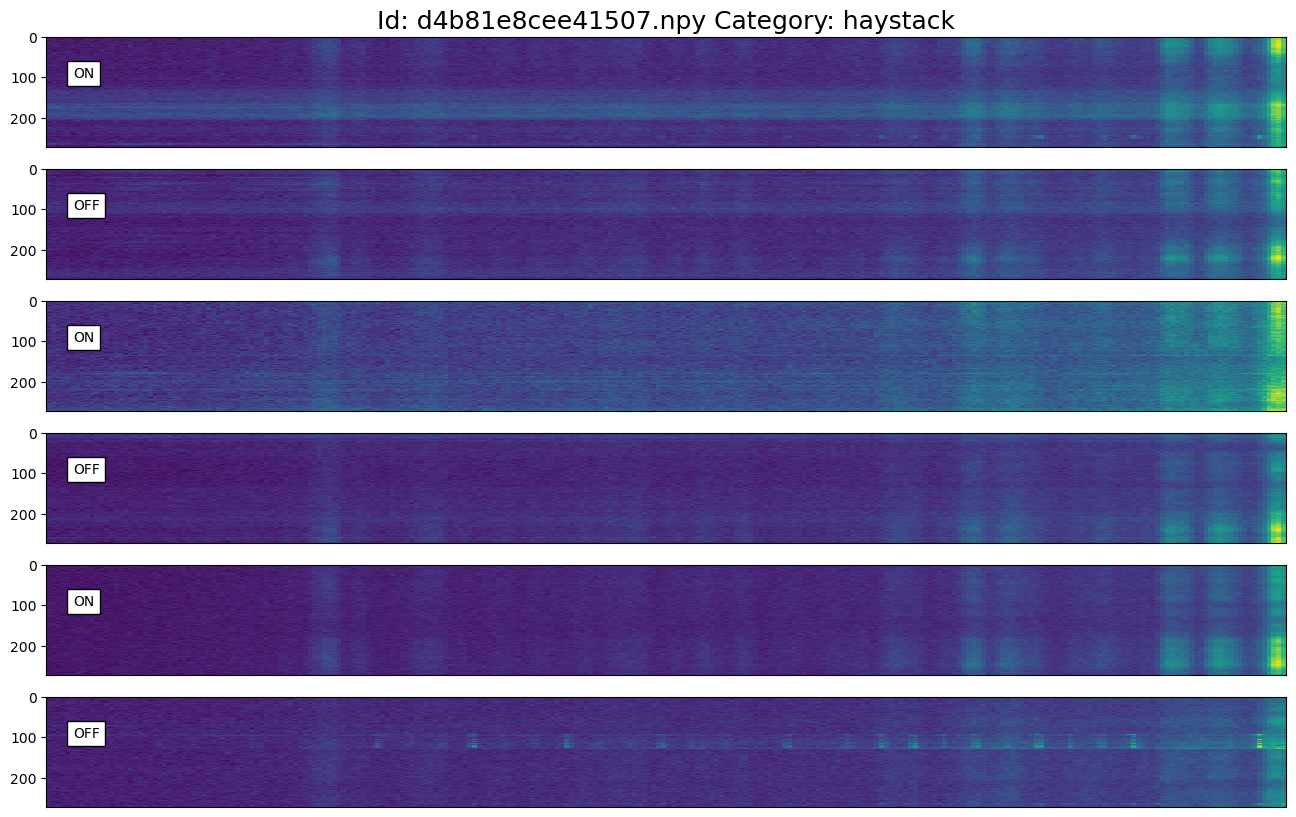

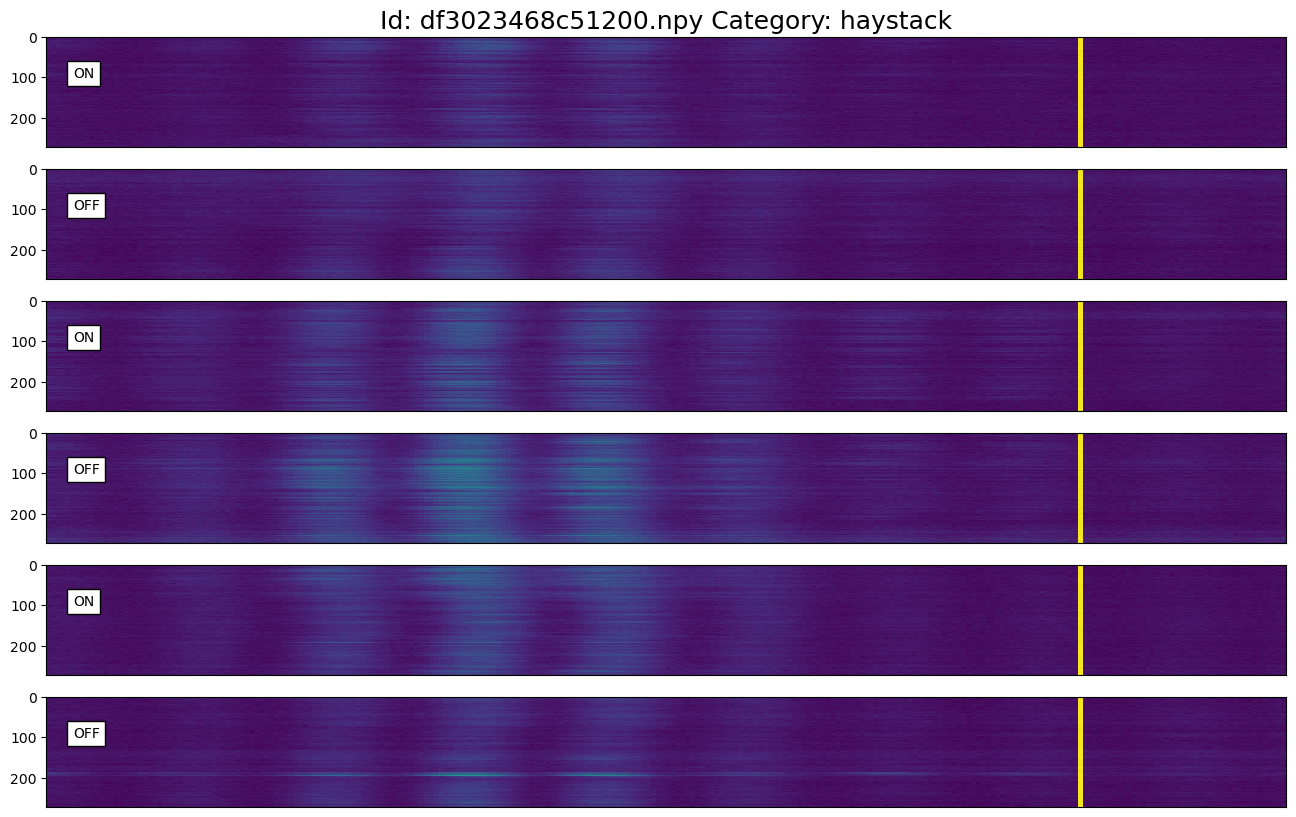

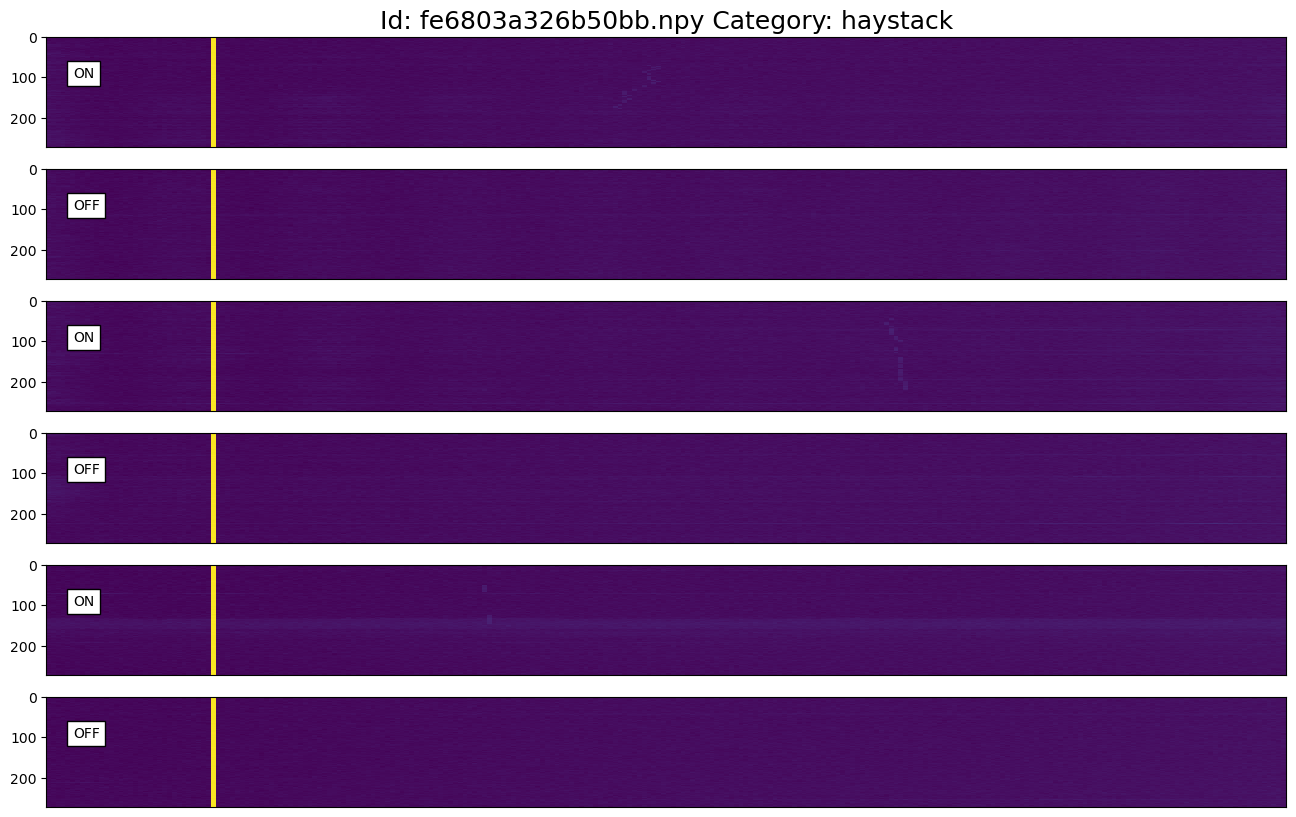

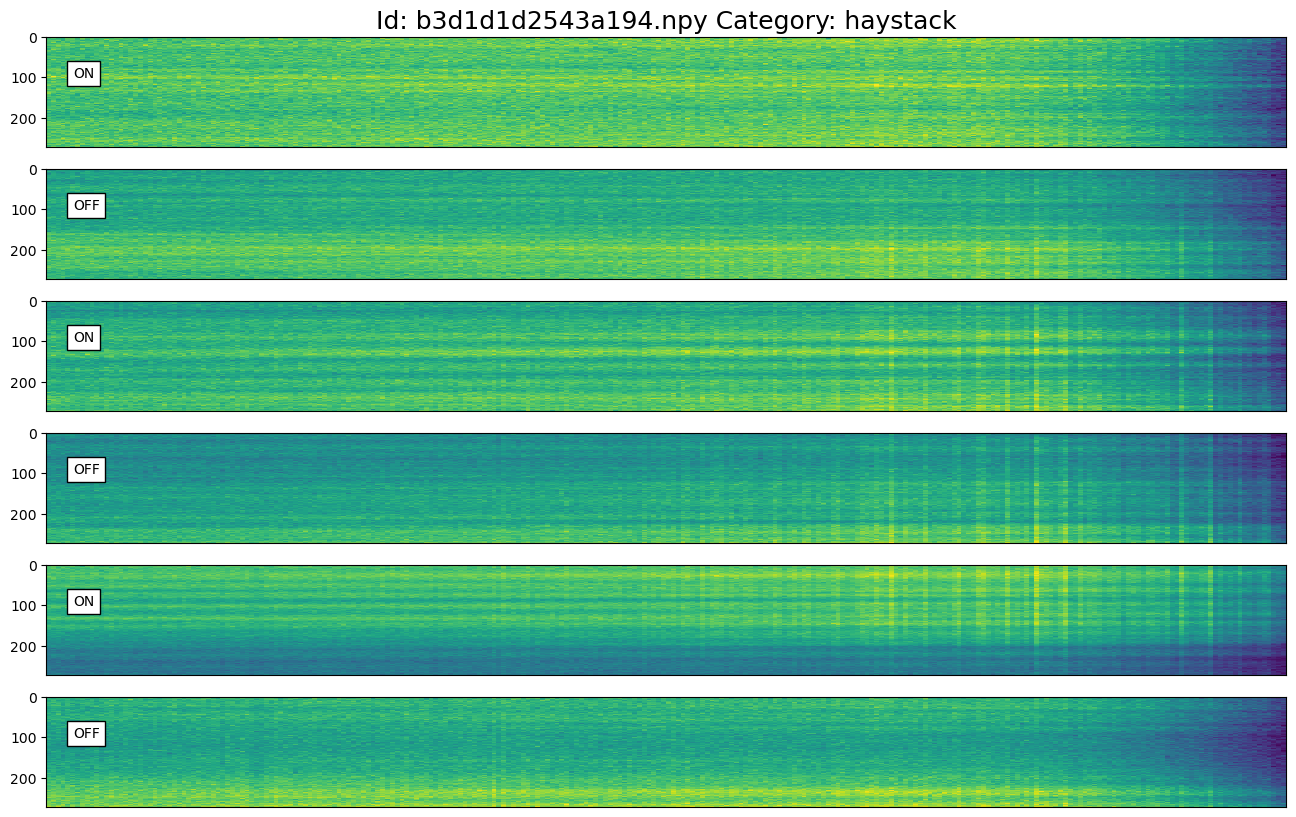

In [ ]:
df_tmp = df_train[df_train["target"] == 0].sample(1)
for ind, row in df_tmp.iterrows():
    show_cadence(get_train_filename_by_id(row["id"]), row["target"])

df_tmp = df_train[df_train["target"] == 1].sample(5)
for ind, row in df_tmp.iterrows():
    show_cadence(get_train_filename_by_id(row["id"]), row["target"])

# **Comparison between categories**

In [ ]:
def show_channels(filename: str, label: int) -> None:
    plt.figure(figsize=(16, 10))
    plt.suptitle(f"Id: {os.path.basename(filename)} Category: {map_semantic[label]}", fontsize=18)
    arr = np.load(filename)
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(arr[i].astype(float))
    plt.show()

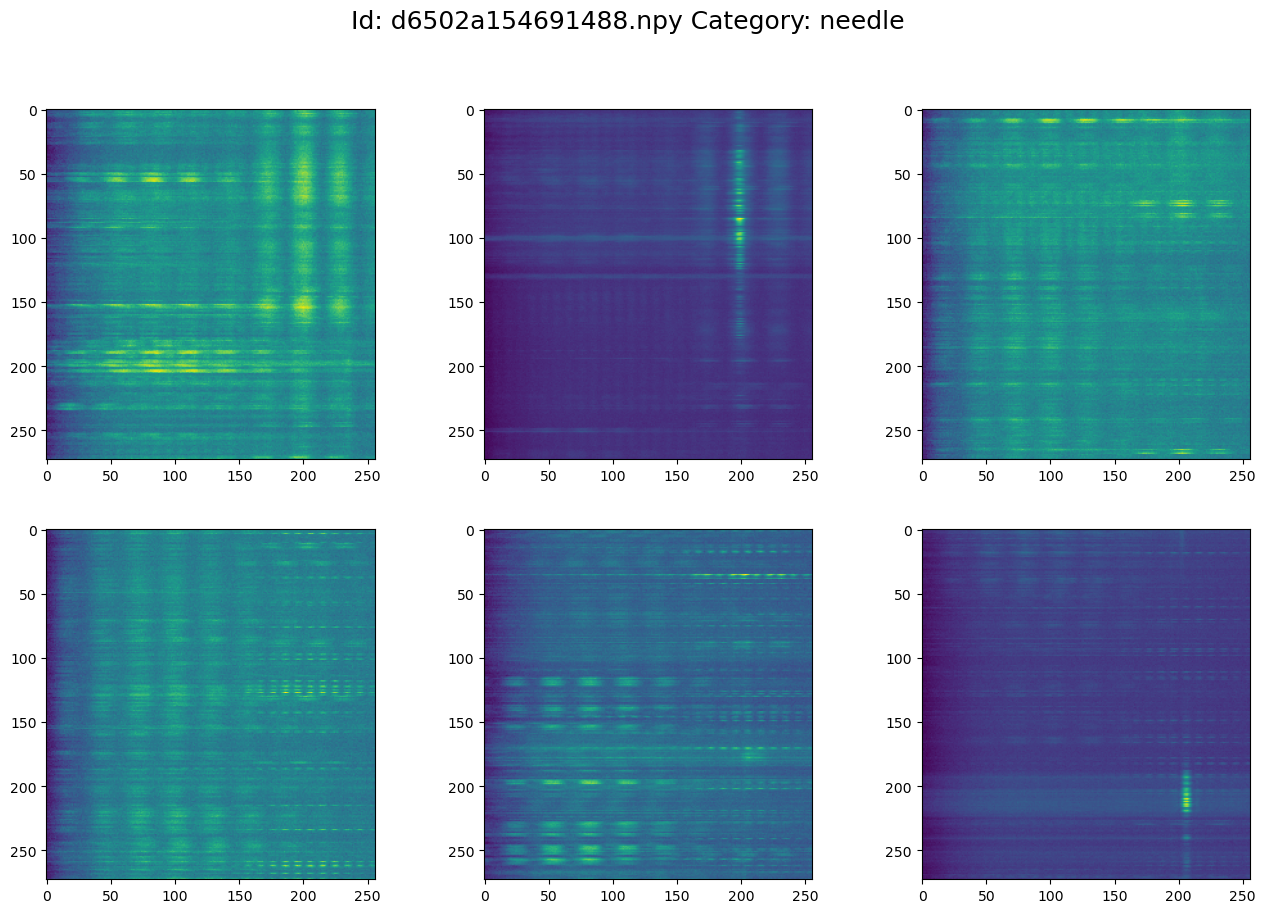

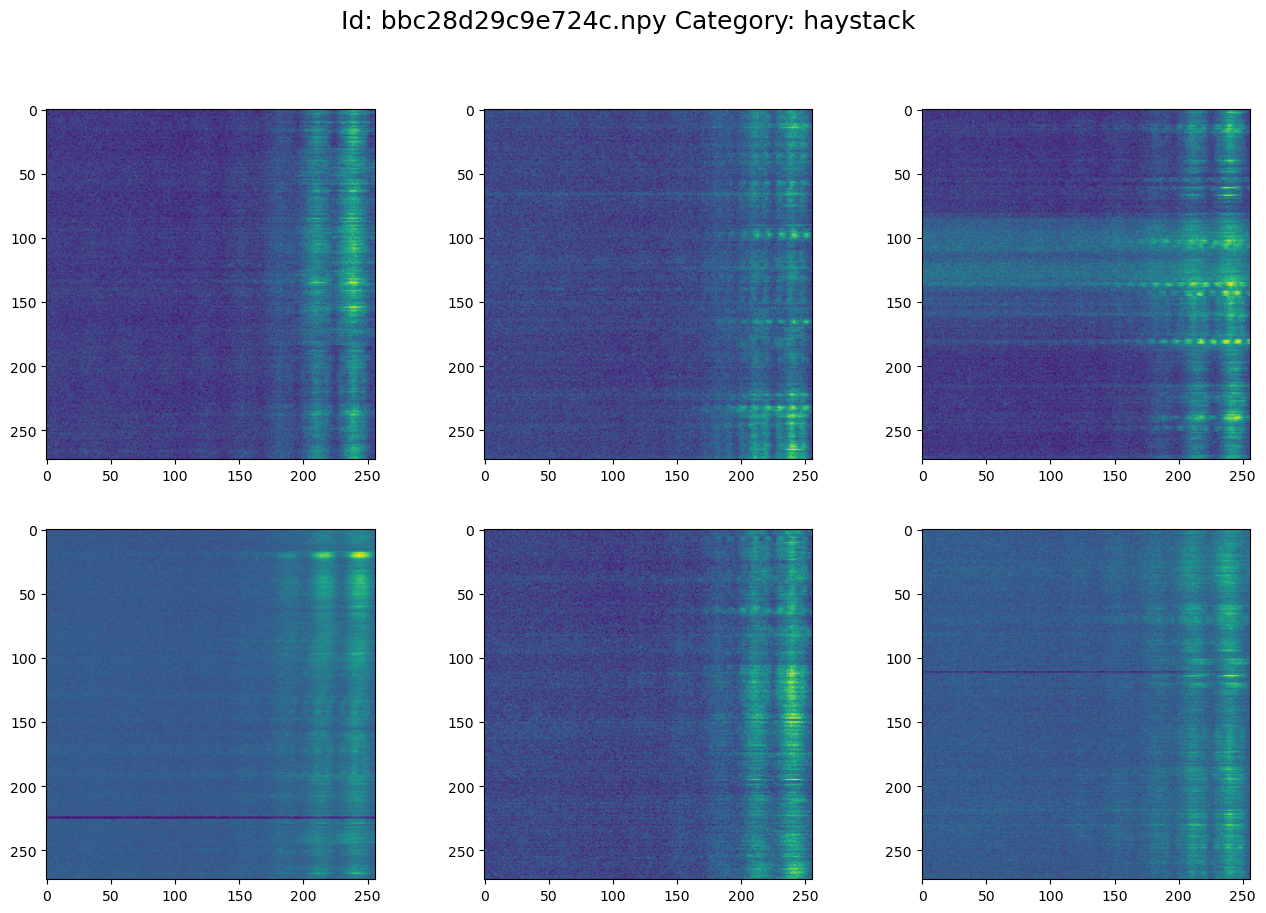

In [ ]:
df_tmp = df_train[df_train["target"] == 0].sample(1)
for ind, row in df_tmp.iterrows():
    show_channels(get_train_filename_by_id(row["id"]), row["target"])

df_tmp = df_train[df_train["target"] == 1].sample(1)
for ind, row in df_tmp.iterrows():
    show_channels(get_train_filename_by_id(row["id"]), row["target"])

# **Cadence spatial**

We have a function called `show_cadence_spatial` where we do the following:

1. There are 6 channels in the images of shape (6, 273, 256) where 273 is the time axis, 256 is the frequency axis and 6 is the 6 cadence snippets. Note that `plt.imshow()` is CxHxW and so the H is the vertical axis which is time axis 273, while W is the horizontal axis which is frequency axis.
> Each file has dimension (6, 273, 256), with the 1st dimension representing the 6 positions of the cadence, and the 2nd and 3rd dimensions representing the 2D spectrogram.

2. Since the following were made clear by the host, we have quite a few options.
    - spatial 6 channels - shape = (273 * 6, 256) or (256, 273 * 6) if you transpose it.
        - We **concatenate** all 6 channels **vertically along the time axis (axis=0)**.
        
    - spatial 3 channels - shape = (273 * 3, 256) or (256, 273 * 3) if you transpose it.
        - We **concatenate** channels 1, 3 and 5 **vertically along the time axis (axis=0)**. Note to me it does not make sense to concatenate channels 1, 3 and 5 along the frequency axis horizontally. As one cadence consists of 6 snippets of different time, therefore, in order to use spatial, one can concateneate along time axis to have a "full overview" of the sequence of events. One can also consider using RNN or time series to model here but I won't use it.
    
    > Not all of the “needle” signals look like diagonal lines, and they may not be present for the entirety of all three “A” observations, but what they do have in common is that they are only present in some or all of the “A” observations (panels 1, 3, and 5 in the cadence snippets).

    - channel wise: We won't be using it here as empirically speaking, it does not perform as well as spatial wise.


![Image](https://i.ibb.co/JFQ44tB/channel-vs-spatial.png)

In [ ]:
def show_cadence_spatial(filename: str, label: int, show_text: bool = True, spatial_mode: str = 'spatial_3ch', transpose: bool = True) -> None:
    """Plot and show cadence as images. Note on channel = odd channels
       This plot shows all 6 cadences with ON and OFF channels. The host says extraterrestrial signals
       should appear in ON channels.

    Args:
        filename (str): [description]
        label (int): [description]
    """
    plt.figure(figsize=(16, 10))
    # load .npy files into np.array
    image_arr = np.load(filename)
    assert image_arr.shape == (6, 273, 256)

    if spatial_mode == 'spatial_3ch':
        image_arr_3ch = image_arr[::2, :, :].astype(np.float32)
        assert image_arr_3ch.shape == (3, 273, 256)
        # print(np.array_equal(image_arr_3ch, image[::2].astype(np.float32), equal_nan=False))
        if transpose is True:
            image_arr_3ch = np.vstack(image_arr_3ch).transpose((1, 0))
            assert image_arr_3ch.shape == (256, 819)
        else:
            image_arr_3ch = np.vstack(image_arr_3ch)
            assert image_arr_3ch.shape == (819, 256)

        plt.title(
            f"Id: {os.path.basename(filename)} Category: {map_semantic[label]}", fontsize=18)
        #plt.subplot(5, 2, i + 1)
        plt.tight_layout()
        plt.imshow(image_arr_3ch)

    elif spatial_mode == 'spatial_6ch':
        # note [:, :, :] produces a verbatim copy of the array
        image_arr_6ch = image_arr[:, :, :].astype(np.float32)
        assert image_arr_6ch.shape == (3, 273, 256)

        if transpose is True:
            image_arr_6ch = np.vstack(image_arr_6ch).transpose((1, 0))
            assert image_arr_6ch.shape == (256, 1638)
        else:
            image_arr_6ch = np.vstack(image_arr_6ch)
            assert image_arr_6ch.shape == (1638, 256)

        #plt.subplot(5, 2, i + 1)
        plt.tight_layout()
        plt.imshow(image_arr_6ch)

    plt.show()

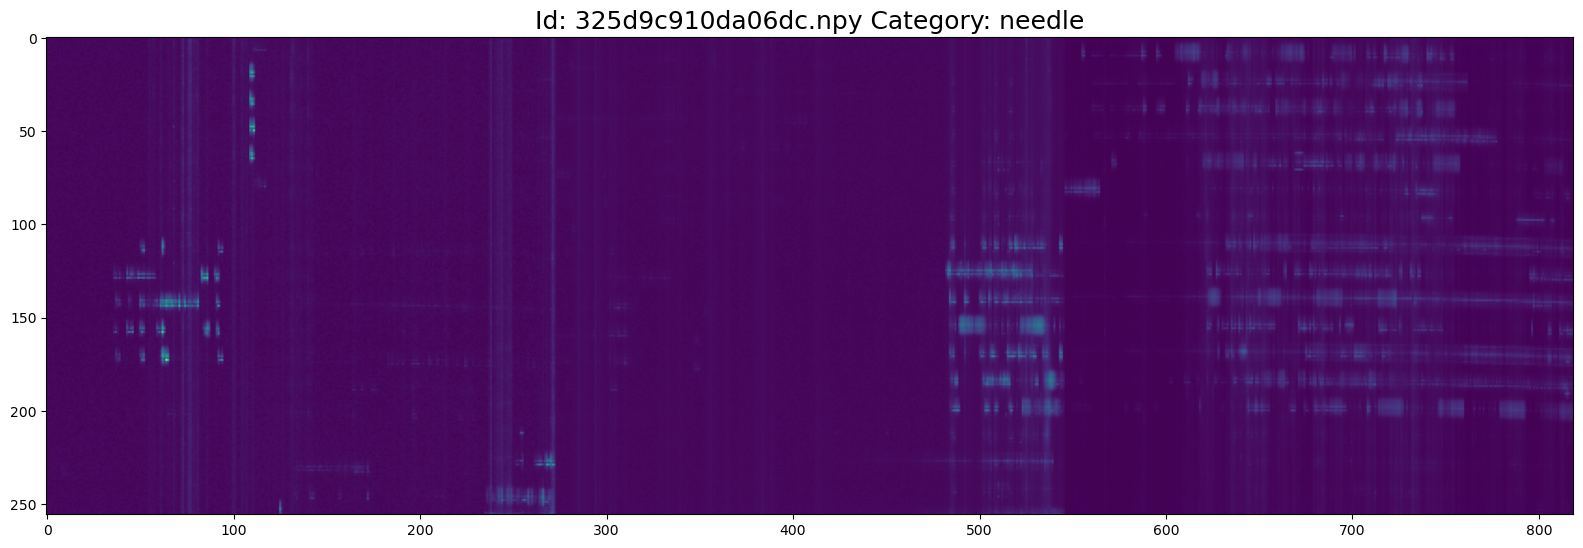

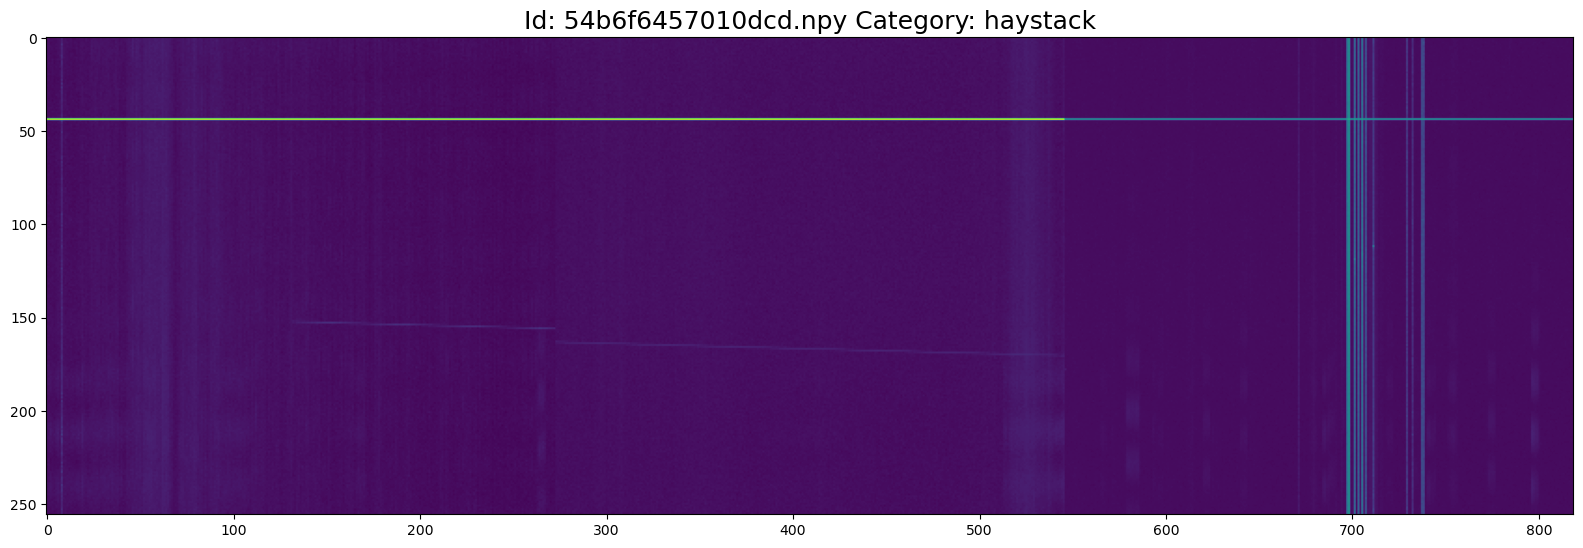

In [ ]:
df_tmp = df_train[df_train["target"] == 0].sample(1)
for ind, row in df_tmp.iterrows():
    show_cadence_spatial(get_train_filename_by_id(row["id"]), row["target"], show_text=True)

df_tmp = df_train[df_train["target"] == 1].sample(1)
for ind, row in df_tmp.iterrows():
    show_cadence_spatial(get_train_filename_by_id(row["id"]), row["target"], show_text=True)

# **Degrees of difficulty**

#### Easy
![](https://i.imgur.com/5ohQpvE.png)

#### Medium
![](https://i.imgur.com/Pz6YdoV.png)
![](https://i.imgur.com/81jL2N7.png)

#### Hard
![](https://i.imgur.com/Sgu0k7n.png)